In [2]:
import pickle
import datetime
from dateutil.parser import parse

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np


import nltk
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#nltk.download()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [3]:
# read data from pickle file
with open ('all_data.pkl', 'rb') as fp:
    df = pickle.load(fp)
    
df.shape

(281105, 3)

In [4]:
# there's some bad data in the snippets.  Drop the rows that have NaN to clean this up
df.dropna(inplace=True)

# take a subset of dataset to try things out
from sklearn.utils import shuffle
#df2 = df.sample(n=150000)
#df2 = shuffle(df2)

df2 = df.copy()

# create an new dataframe that combines the headline and snippet (more words in document)
df2['head_snip'] = df['headline'] + ' '+ df['snippet']

dates = list(df2['date'])

documents = list(df2['headline'])

df2.columns

Index(['date', 'headline', 'snippet', 'head_snip'], dtype='object')

In [266]:
df2['head_snip'].to_csv('documents.csv')

## functions

In [5]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print(f"Topic {topic_idx} (with {len(np.unique(W[:,topic_idx]))} articles)")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        #print(top_doc_indices, np.argsort(W[:,topic_idx]))
        for doc_index in top_doc_indices:
            print('document with index',doc_index)
            print(documents[doc_index])
        print(' ')

In [316]:
len(lda_W)

20

In [6]:
import matplotlib.pyplot as plt

def plot_topic_trend_lda(H, W, documents, dates):
    plt.figure(figsize=(17,8))
    min_date = min(dates)
    max_date = max(dates)
    min_year, min_week, weekday = min_date.isocalendar()
    max_year, max_week, weekday = max_date.isocalendar()

    plot_data_all = pd.DataFrame(columns=['topic','date','num_docs'])
    week_start = min_week
    week_end = (max_year-min_year)*52+max_week + 1

    w = week_end - week_start

    for topic in range(len(H)):
        for week in range(week_start,week_end): 
            #print(w*topic+week, topic, week)
            plot_data_all.at[w*topic+week,'topic'] = topic
            plot_data_all.at[w*topic+week,'date'] = week
    plot_data_all['num_docs'] = 0
    plot_data_all = plot_data_all.astype('int')    
    
    #print(plot_data_all)
    print('set up dataframe for data',plot_data_all.info())
    print('weeks in dataframe',week_start, week_end, w)
    
    for doc_idx in range(W.shape[0]):
        try:
            topic_idx = W[doc_idx].argmax()

            date_key = dates[doc_idx]
            year, week, weekday = date_key.isocalendar()
            if year == 2016:   # 2015 gets weeks 1-52, subsequent years have to add multiples of 52 to week number
                week += 52
            elif year == 2017:
                week += 104
            elif year == 2018:
                week += 156
            #print(w*topic_idx+week)
            plot_data_all.loc[w*topic_idx + week,'num_docs'] +=  1
        except:
            topic_idx = W[doc_idx].argmax()
            date_key = dates[doc_idx]
            year, week, weekday = date_key.isocalendar()

            print(year, week,'did not work')
            print(w*topic_idx + week)
        
    for topic in range(len(H)):
        foo = plot_data_all[plot_data_all['topic'] == topic]
        plt.plot(foo['date'],foo['num_docs'],label=f'Topic {topic}')
    plt.legend(loc='upper left');
    return
#    return plot_data_all



## LDA

In [138]:
# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
#tf = tf_vectorizer.fit_transform(documents)
tf_vectorizer = CountVectorizer(
            max_df = 0.95, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [104]:
print(len(tf_feature_names))

122999


In [105]:
print(documents)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [139]:
no_topics = 20

# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.fit_transform(tf)
lda_H = lda_model.components_

## bunch of different models to run in a row

In [144]:
tf_vectorizer = CountVectorizer(
            max_df = 0.95, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
print('5 topics')
no_topics = 5
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
with open('lda_model_11.11_5topics95.pkl', 'wb') as fp:
    pickle.dump(lda_model, fp)
print('10 topics')
no_topics = 10
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
with open('lda_model_11.11_10topics95.pkl', 'wb') as fp:
    pickle.dump(lda_model, fp)

5 topics
10 topics


In [146]:
tf_vectorizer = CountVectorizer(
            max_df = 0.75, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
print('5 topics')
no_topics = 5
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
with open('lda_model_11.11_5topics75.pkl', 'wb') as fp:
    pickle.dump(lda_model, fp)
print('10 topics')
no_topics = 10
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
with open('lda_model_11.11_10topics75.pkl', 'wb') as fp:
    pickle.dump(lda_model, fp)
print('20 topics')
no_topics = 20
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
with open('lda_model_11.11_20topics75.pkl', 'wb') as fp:
    pickle.dump(lda_model, fp)q

5 topics
10 topics
20 topics


In [ ]:
# read in and examine stored models

tf_vectorizer = CountVectorizer(
            max_df = 0.75, # leave out words that occur in more than 95% of docs
            min_df = 2,    # leave out if occurs less than twice
            ngram_range=(1,3),
            stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

with open('lda_model_11.11_5topics75.pkl', 'rb') as fp:
    lda_model = pickle.load(fp)
lda_W = lda_model.fit_transform(tf)
lda_H = lda_model.components_

no_top_words = 10
no_top_documents = 2
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

plot_topic_trend_lda(lda_H, lda_W, documents, dates)

pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer)

Topic 0 (with 255576 articles)
man say california make trade win tax good police old
document with index 43932
Para bajar de peso, dedica menos tiempo al gimnasio y más tiempo a comer sano
document with index 43892
Para bajar de peso, dedica menos tiempo al gimnasio y más tiempo a comer sano
 
Topic 1 (with 255576 articles)
trump review says day donald time donald trump 8217 president america
document with index 57994
Hillary Clinton Says Donald Trump&#8217;s &#8216;Outrageous&#8217; Comments Are Part of a Republican Theme
document with index 84317
Bill Clinton to Appear for &#8216;Super PAC&#8217; Backing Hillary Clinton
 
Topic 2 (with 255576 articles)
new york new york house art court election big year health
document with index 273125
Flash Flooding in Connecticut, New Jersey and New York Turns Roads Into Rivers
document with index 273108
Flash Flooding in Connecticut, New Jersey and New York Turns Roads Into Rivers
 
Topic 3 (with 255576 articles)
briefing paid notice paid notice 

In [51]:
no_top_words = 10
no_top_documents = 5
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

Topic 0 (with 138 articles)
dies gay court change black agenda high state supreme court 18 24
[ 12 173  45 193  78] [ 30 118  63  17 144 140 194 123 135  80   2 150  54 168  31 132  11 124
  40 154 107  67 149  24  65 191  32  29  46  14  52 157 187  34 125  16
 102  50 156  83  41 100 105 104  75   5 167 179  21 138 146 101 172 137
 119  53 134   6  66  42 129 113 116 141  64 130 151  44 160 189  97 185
   0  61  26 183 188 192 184   3 133  84 174  93 155 131 182 136 106  79
  59  18 109 171  57 122  51  77  72  60  62 190 110 139  15  74 148 142
  25 145 143 159 153 158  37  10 161 163 164   8 176 178 181 186   1 152
  38  73  85  56 108 111 112  88  68 114  95  49  48  98 126  81  70  71
  76  69 117  28 180  92  90  82 196 121  94  58 120   4  91  43 103  96
 169 175   7 147 127   9 170 197  36  13 162  22 165  35 128  87  89  55
  33  19  27 166  23 177 198  47 115 195  99 199  39  86  20  78 193  45
 173  12]
document with index 12
Climate Change High on Agenda as Obama and Trude

In [ ]:
print(lda_H)

In [141]:
# write model to file (or read from file)

write = True # True if write to file
             # False if read from file
if write == True:
    # write data to pickle file
    with open('lda_model.pkl', 'wb') as fp:
        pickle.dump(lda_model, fp)

elif write == False:
    # read data from pickle file
    with open('lda_model.pkl', 'rb') as fp:
        lda_model = pickle.load(fp)


In [ ]:
'''
topic_idx = 4
foo = nmf_W[:,topic_idx]
new_array = foo[np.where(foo != 0.)]
for index in np.argsort(new_array):    
    print(index)
print(len(new_array))
'''

In [209]:
for n in range(lda_W.shape[0]):
    topic_most_pr = lda_W[n].argmax()
    print("doc: {} topic: {}\n".format(n,topic_most_pr))

doc: 0 topic: 2

doc: 1 topic: 1

doc: 2 topic: 15

doc: 3 topic: 3

doc: 4 topic: 0

doc: 5 topic: 2

doc: 6 topic: 10

doc: 7 topic: 10

doc: 8 topic: 8

doc: 9 topic: 0

doc: 10 topic: 3

doc: 11 topic: 4

doc: 12 topic: 10

doc: 13 topic: 0

doc: 14 topic: 10

doc: 15 topic: 4

doc: 16 topic: 0

doc: 17 topic: 0

doc: 18 topic: 1

doc: 19 topic: 8



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4020 entries, 1 to 4020
Data columns (total 3 columns):
topic       4020 non-null int64
date        4020 non-null int64
num_docs    4020 non-null int64
dtypes: int64(3)
memory usage: 285.6 KB
set up dataframe for data None
weeks in dataframe 1 202 201


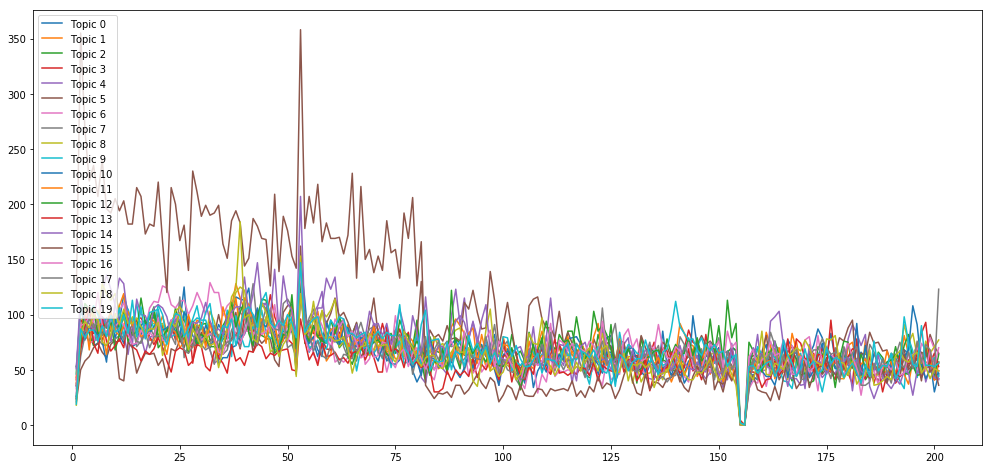

In [140]:
plot_topic_trend_lda(lda_H, lda_W, documents, dates)
#plot_data_all  = plot_topic_trend(lda_H, lda_W, documents, dates)

In [60]:
# write data to csv file for reading into Tableau

outfile = open( 'plot_data_all_lda.csv', 'w' )
for i in range(len(plot_data_all)):
    for key, value in sorted( plot_data_all[:][i].items() ):
        outfile.write( str(i) + ',' + str(key) + ',' + str(value) + '\n' )
#        outfile.write( str(i) + '\t' + str(key) + '\t' + str(value) + '\n' )
#        print( str(i) + '\t' + str(key) + '\t' + str(value) + '\n' )
outfile.close()

In [142]:
import pyLDAvis.gensim
import pyLDAvis.sklearn

import gensim
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.251650  0.001262       1        1  8.596989
14    -0.239245 -0.001070       2        1  5.748669
9     -0.248679 -0.016535       3        1  5.587422
12     0.053120 -0.414634       4        1  5.492209
4      0.054086  0.055597       5        1  5.169422
13     0.041177  0.034309       6        1  5.041020
11     0.032228  0.036516       7        1  4.896243
8      0.040432  0.029516       8        1  4.874262
10     0.047446 -0.073599       9        1  4.834086
5      0.050938  0.023903      10        1  4.797503
1      0.034291  0.040131      11        1  4.770793
16     0.048767  0.032680      12        1  4.730430
19     0.053179  0.015390      13        1  4.685788
6      0.015767  0.029540      14        1  4.637274
3      0.040240  0.043999      15        1  4.625008
2      0.042559  0.029603      16        1  4.623636
7      0.046744  0.030257      17        1  4.342930
17     0.046189  0.028803      18        1  4.247113
18     0.048198  0.036039      19        1  4.159610
0      0.044214  0.038295      20        1  4.139593, topic_info=       Category          Freq                Term         Total  loglift  \
term                                                                       
233614  Default  15039.000000               trump  15039.000000  30.0000   
154355  Default  20964.000000                 new  20964.000000  29.0000   
254121  Default   9592.000000                york   9592.000000  28.0000   
156058  Default   9579.000000            new york   9579.000000  27.0000   
190920  Default   7451.000000              review   7451.000000  26.0000   
166696  Default   6446.000000                paid   6446.000000  25.0000   
158423  Default   6186.000000              notice   6186.000000  24.0000   
166709  Default   6143.000000         paid notice   6143.000000  23.0000   
59011   Default   5888.000000              deaths   5888.000000  22.0000   
31380   Default   4426.000000            briefing   4426.000000  21.0000   
166710  Default   5505.000000  paid notice deaths   5505.000000  20.0000   
158424  Default   5505.000000       notice deaths   5505.000000  19.0000   
68027   Default   3853.000000                dies   3853.000000  18.0000   
246565  Default   3855.000000                week   3855.000000  17.0000   
57404   Default   3506.000000                 day   3506.000000  16.0000   
44007   Default   4164.000000                city   4164.000000  15.0000   
71070   Default   3878.000000              donald   3878.000000  14.0000   
251653  Default   3146.000000               world   3146.000000  13.0000   
200678  Default   3737.000000                says   3737.000000  12.0000   
42112   Default   2885.000000               china   2885.000000  11.0000   
229779  Default   3457.000000               today   3457.000000  10.0000   
109044  Default   2511.000000               house   2511.000000   9.0000   
250353  Default   2444.000000               women   2444.000000   8.0000   
228841  Default   2377.000000                time   2377.000000   7.0000   
2385    Default   2425.000000                2018   2425.000000   6.0000   
157944  Default   2297.000000               north   2297.000000   5.0000   
237198  Default   2228.000000                  tv   2228.000000   4.0000   
131115  Default   2213.000000                life   2213.000000   3.0000   
71089   Default   2144.000000        donald trump   2144.000000   2.0000   
244653  Default   2214.000000                 war   2214.000000   1.0000   
...         ...           ...                 ...           ...      ...   
252965  Topic20   1026.900886             yankees   1027.738900   3.1838   
243517  Topic20    819.227210                  vs    820.065224   3.1836   
38956   Topic20    629.428750              center    630.266764   3.1832   
242186  Topic20    548.376955            violence    54

## using Word2Vect

In [ ]:
import os

# Setup nltk corpora path and Google Word2Vec location
google_vec_file = '/Users/dana/metis/GoogleNews-vectors-negative300.bin'

In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [ ]:
headline = df2['headline'][0:10]
print(headline)

In [ ]:
print(stop_words)

In [ ]:
headline = df2['headline'][0:10]

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

for index, row in headline.iteritems():
    word_tokens = word_tokenize(row)

    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    stemmed_sentence = [ps.stem(w) for w in filtered_sentence]
    print(stemmed_sentence)#model.word_vec('word')

In [ ]:
for index, row in headline.iteritems():
    word_tokens = word_tokenize(row)

    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    #stemmed_sentence = [ps.stem(w) for w in filtered_sentence]
    stemmed_sentence = filtered_sentence
    print(stemmed_sentence)#model.word_vec('word')
    
    headline_vec = []

    for word in stemmed_sentence:
        try:
            vec = model.word_vec(word)
            headline_vec.append(vec)

        except:
            print('*not found*   ', word)

    print(len(headline_vec))
    print('')

In [ ]:
print(len(headline_vec))